In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
import math
import time

In [16]:
class MLP:

    def __init__(self, weights, bias, num_outputs=1, num_hidden=1, activation_function="sigmoid"):
        self.weights = weights
        self.bias = bias
        self.activation_function = activation_function
        self.num_hidden = len(weights) - 1
        self.num_neurons = [weights[0].shape[0]]

        for i in range(len(weights)):
            self.num_neurons.append(weights[i].shape[1])
        self.num_inputs = self.num_neurons[0]
        self.num_outputs = self.num_neurons[-1]

        # verify if dimensions are correct
        for i in range(len(weights) - 1):
            if (weights[i].shape[1] != weights[i + 1].shape[0]):
                print("Weights' dimensions between layers " + str(i) + " and " + str(i + 1) + "are incorrect!")
        for i in range(len(bias)):
            if (weights[i].shape[1] != bias[i].size):
                print("Bias size in layer " + str(i) + " is incorrect!")

    def forward_prop(self, inputs):
        """
        performs forward propagation
        """
        # activations and linear combinations passed to activation function
        self.a = []
        self.z = []

        activation_function = self.get_activation_function(self.activation_function)
        activations = inputs
        self.a.append(activations)
        for i in range(self.num_hidden):
            outputs = np.dot(activations, self.weights[i]) + self.bias[i]
            self.z.append(outputs)
            activations = activation_function(outputs)
            self.a.append(activations)

        results = np.dot(activations, self.weights[self.num_hidden]) + self.bias[self.num_hidden]
        self.z.append(results)
        self.a.append(results)
        return results

    def backpropagation(self, y):
        """
        backpropagataes error to calculate derivatives
        """
        deltas = [None] * len(self.weights)
        deltas[-1] = y - self.a[-1]
        for i in reversed(range(len(deltas) - 1)):
            deltas[i] = (self.weights[i + 1].dot(deltas[i + 1].T) * (
                self.get_activation_function_derivitive(self.activation_function)(self.z[i]).T)).T
        
        batch_size = y.shape[0]
        db = [d.T.dot(np.ones((batch_size, 1))).T / float(batch_size) for d in deltas]
        dw = [(d.T.dot(self.a[i])).T / float(batch_size) for i, d in enumerate(deltas)]
        return dw, db

    def train(self, x, y, epochs = 500, learning_rate = 0.1, batch_size = None, verbose = False):
        """
        train network
        """
        if batch_size is None:
            batch_size = x.shape[0]
        for epoch in range(epochs):
            i = 0
            batch_counter = 0
            while i < len(y):
                batch_counter += 1
                x_batch = x[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                i = i + batch_size
                
                self.forward_prop(x_batch)
                dw, db = self.backpropagation(y_batch)
                
                self.weights = [w + learning_rate * dweight for w, dweight in zip(self.weights, dw)]
                self.bias = [w + learning_rate * dbias for w, dbias in zip(self.bias, db)]
                if verbose or epoch in [0,epochs-1]:
                    if batch_size == x.shape[0]:
                        print("Epoch: {: <5} Error: {}".format(epoch, np.linalg.norm(self.a[-1] - y_batch)))
                    else:
                        print("Epoch: {: <5} Batch: {: <3} Error: {}".
                              format(epoch+1, batch_counter, np.linalg.norm(self.a[-1] - y_batch)))
        return
                        
    def train_momentum(self, x, y, epochs = 500, learning_rate = 0.01, momentum_factor = 0.9, verbose = False):
        """
        train network with momentum
        """
        momentum_w = []
        momentum_b = []
        for i in range(len(self.num_neurons)-1):
            momentum_w.append(np.zeros(self.num_neurons[i] * self.num_neurons[i+1]).reshape(self.num_neurons[i],-1))
            momentum_b.append(np.zeros(self.num_neurons[i+1]).reshape(1,-1))
        
        for epoch in range(epochs):
            self.forward_prop(x)
            dw, db = self.backpropagation(y)
            
            # momentum = gradient + lambda * momentum
            momentum_w = [dweight + momentum_factor * momentum_prev for dweight, momentum_prev in zip(dw, momentum_w)]
            momentum_b = [dbias + momentum_factor * momentum_prev for dbias, momentum_prev in zip(db, momentum_b)]
            
            self.weights = [w + learning_rate * weight_momentum for w, weight_momentum in zip(self.weights, momentum_w)]
            self.bias = [w + learning_rate * bias_momentum for w, bias_momentum in zip(self.bias, momentum_b)]
            
            if verbose or epoch in [0,epochs-1]:
                print("Epoch: {: <5} Error: {}".format(epoch, np.linalg.norm(self.a[-1] - y)))
        return
    
    def train_rmsPROP(self, x, y, epochs = 500, learning_rate = 0.1, beta = 0.9, batch_size=None, verbose = False):
        """
        train network using rmsPROP
        """
        
        v_w = []
        v_b = []
        for i in range(len(self.num_neurons)-1):
            v_w.append(np.zeros(self.num_neurons[i] * self.num_neurons[i+1]).reshape(self.num_neurons[i],-1))
            v_b.append(np.zeros(self.num_neurons[i+1]).reshape(1,-1))
        
        if batch_size is None:
            batch_size = x.shape[0]
        for epoch in range(epochs):
            i = 0
            batch_counter = 0
            while i < len(y):
                batch_counter += 1
                x_batch = x[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                i = i + batch_size
                
                self.forward_prop(x_batch)
                dw, db = self.backpropagation(y_batch)
                
                for ii, w_matrix in enumerate(v_w):
                    for j, row in enumerate(w_matrix):
                        for k, value in enumerate(row):
                            v_w[ii][j][k] = beta * v_w[ii][j][k] + (1-beta) * (dw[ii][j][k]**2)
                            
                for ii, w_matrix in enumerate(v_b):
                    for j, row in enumerate(w_matrix):
                        for k, value in enumerate(row):
                            v_b[ii][j][k] = beta * v_b[ii][j][k] + (1-beta) * (dw[ii][j][k]**2)
                            
                
                self.weights = [w + learning_rate * dweight / np.sqrt(v) for w, dweight, v in zip(self.weights, dw, v_w)]
                self.bias = [w + learning_rate * dbias / np.sqrt(v) for w, dbias, v in zip(self.bias, db, v_b)]
                if verbose or epoch in [0,epochs-1]:
                    if batch_size == x.shape[0]:
                        print("Epoch: {: <5} Error: {}".format(epoch, np.linalg.norm(self.a[-1] - y_batch)))
                    else:
                        print("Epoch: {: <5} Batch: {: <3} Error: {}".
                              format(epoch+1, batch_counter, np.linalg.norm(self.a[-1] - y_batch)))
        return
                    
    @staticmethod
    def get_activation_function(name):
        if (name == 'sigmoid'):
            return lambda x: np.exp(x) / (1 + np.exp(x))
        elif (name == 'linear'):
            return lambda x: x
        else:
            print('Wrong activation function; linear was used instead')
            return lambda x: x

    @staticmethod
    def get_activation_function_derivitive(name):
        if (name == 'sigmoid'):
            sigmoid = lambda x: np.exp(x) / (1 + np.exp(x))
            return lambda x: sigmoid(x) * (1 - sigmoid(x))
        elif (name == 'linear'):
            return lambda x: 1
        else:
            print('Wrong activation function; linear was used instead')
            return lambda x: 1

    def show_attributes(self):
        """
        gives basic information about the neural network
        """
        print("Neural Network attributes:")
        print("-------------------------")
        print("Number of neurons in layers: {}".format(self.num_neurons))
        print("Number of predictors: {}".format(self.num_inputs))
        print("Number of hidden layers: {}".format(self.num_hidden))
        print("Number of targets: {}".format(self.num_outputs))
        print("Activations function used: {}".format(self.activation_function))
        return
    
    def visualize(self, axis = False):
        """
        displays graph visualization for neural network 
        """
        x = []
        y = []
        all_weights = []
        all_biases = [None]
        
        for weight in self.weights:
            for row in weight:
                for i in row:
                    all_weights.append(round(i,2))
        for bias in self.bias:
            for row in bias:
                for i in row:
                    all_biases.append(round(i,2))
        weight_counter = 0
        bias_counter = 0
        
        plt.figure(figsize=(20,10))
        
        for i, layer in enumerate(self.num_neurons):            
            layer_points_x = [i] * layer
            layer_points_y = np.linspace(-10, 10, num=layer)
            if layer == 1:
                layer_points_y[0] += 10
            if i==0:
                    previous_layer_x = layer_points_x
                    previous_layer_y = layer_points_y
            else:
                for l1 in previous_layer_y:
                    for l2 in layer_points_y:
                        plt.plot([i-1, i],[l1, l2], color="lightblue")
                        plt.text(i-0.3,0.3*l1+0.7*l2, all_weights[weight_counter], size=15)
                        weight_counter += 1
                previous_layer_x = layer_points_x
                previous_layer_y = layer_points_y
            
            x.extend(layer_points_x)
            y.extend(layer_points_y)
            
        plt.scatter(x,y, color="brown", s=75)
        
        for i, txt in enumerate(all_biases):
            plt.annotate(txt, (x[i], y[i]+0.5), size=15)
        if not axis:
            plt.axis("off")
        plt.title("Neural network graph", fontsize=20)
        plt.show()
        return


def generate_random_mlp(num_inputs, num_hidden, num_targets, start=0, stop=1):
    """
    generates mlp with random weights given number of neurons in each layer
    """
    weights = []
    bias = []
    weights.append(np.random.uniform(start, stop, num_inputs * num_hidden[0]).reshape(num_inputs, -1))
    for i in range(len(num_hidden) - 1):
        weights.append(np.random.uniform(start, stop, num_hidden[i] * num_hidden[i + 1]).reshape(num_hidden[i], -1))
        bias.append(np.random.uniform(start, stop, num_hidden[i]).reshape(1, -1))
    weights.append(np.random.uniform(start, stop, num_hidden[-1] * num_targets).reshape(-1, num_targets))
    bias.append(np.random.uniform(start, stop, num_hidden[-1]).reshape(1, -1))
    bias.append(np.random.uniform(start, stop, num_targets).reshape(1, -1))
    mlp = MLP(weights, bias)
    return mlp

### Pierwszy zbiór: square-simple

Text(0.5, 1.0, 'Train split')

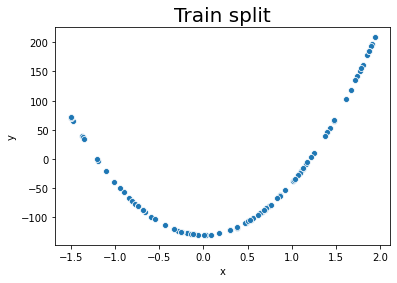

In [26]:
train_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/regression/square-simple-training.csv', index_col=0)
test_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/regression/square-simple-test.csv', index_col=0)
sns.scatterplot(x='x', y='y', data=train_df)
plt.title('Train split', fontsize=20)

Neural Network attributes:
-------------------------
Number of neurons in layers: [1, 4, 1]
Number of predictors: 1
Number of hidden layers: 1
Number of targets: 1
Activations function used: sigmoid
Epoch: 0     Error: 1011.9539304872341
Epoch: 2999  Error: 473.63440156887526


Text(0.5, 1.0, 'Test performance standard')

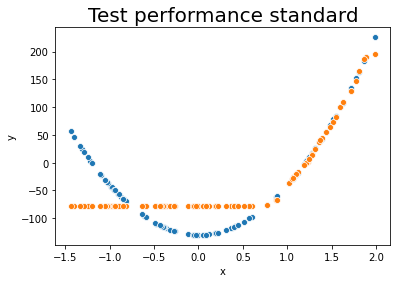

In [43]:
mymlp = generate_random_mlp(1, [4], 1)
mymlp.show_attributes()
mymlp.train(np.asarray(train_df['x']).reshape(-1,1), np.asarray(train_df['y']).reshape(-1,1), 3000, 0.05)
result = mymlp.forward_prop(np.asarray(test_df['x']).reshape(-1,1))
sns.scatterplot(x='x', y='y', data=test_df)
sns.scatterplot(x=test_df['x'], y=np.concatenate(result))
plt.title('Test performance standard', fontsize=20)

Neural Network attributes:
-------------------------
Number of neurons in layers: [1, 4, 1]
Number of predictors: 1
Number of hidden layers: 1
Number of targets: 1
Activations function used: sigmoid
Epoch: 0     Error: 1011.5225257599218
Epoch: 2999  Error: 477.32543054263374


Text(0.5, 1.0, 'Test performance with momentum')

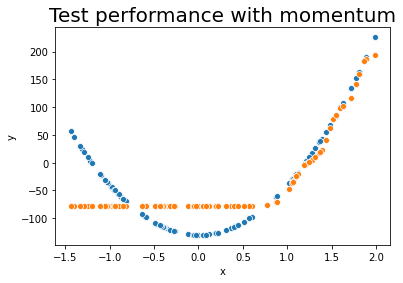

In [48]:
mymlp = generate_random_mlp(1, [4], 1)
mymlp.show_attributes()
mymlp.train_momentum(np.asarray(train_df['x']).reshape(-1,1), np.asarray(train_df['y']).reshape(-1,1), 3000, 0.05, 0.9)
result = mymlp.forward_prop(np.asarray(test_df['x']).reshape(-1,1))
sns.scatterplot(x='x', y='y', data=test_df)
sns.scatterplot(x=test_df['x'], y=np.concatenate(result))
plt.title('Test performance with momentum', fontsize=20)

Neural Network attributes:
-------------------------
Number of neurons in layers: [1, 4, 1]
Number of predictors: 1
Number of hidden layers: 1
Number of targets: 1
Activations function used: sigmoid
Epoch: 0     Error: 1007.0891359662054
Epoch: 2999  Error: 473.5007500890645


Text(0.5, 1.0, 'Test performance with rmsprop')

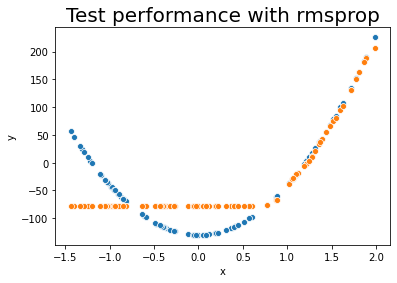

In [47]:
mymlp = generate_random_mlp(1, [4], 1)
mymlp.show_attributes()
mymlp.train_rmsPROP(np.asarray(train_df['x']).reshape(-1,1), np.asarray(train_df['y']).reshape(-1,1), 3000, 0.1, 0.9)
result = mymlp.forward_prop(np.asarray(test_df['x']).reshape(-1,1))
sns.scatterplot(x='x', y='y', data=test_df)
sns.scatterplot(x=test_df['x'], y=np.concatenate(result))
plt.title('Test performance with rmsprop', fontsize=20)

### Drugi zbiór: steps-large

Text(0.5, 1.0, 'Train split')

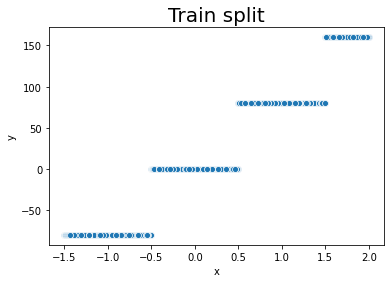

In [17]:
train_df = pd.read_csv('/home/szwagier/Documents/Sem6/MIO/datasets/regression/steps-large-training.csv', index_col=0)
test_df = pd.read_csv('/home/szwagier/Documents/Sem6/MIO/datasets/regression/steps-large-test.csv', index_col=0)
sns.scatterplot(x='x', y='y', data=train_df)
plt.title('Train split', fontsize=20)

Neural Network attributes:
-------------------------
Number of neurons in layers: [1, 4, 1]
Number of predictors: 1
Number of hidden layers: 1
Number of targets: 1
Activations function used: sigmoid
Epoch: 0     Error: 8562.07658419264
Epoch: 2999  Error: 659.1404973057355


Text(0.5, 1.0, 'Test performance standard')

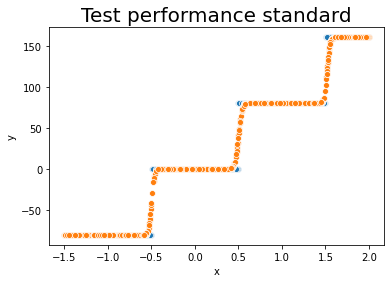

In [21]:
mymlp = generate_random_mlp(1, [4], 1)
mymlp.show_attributes()
mymlp.train(np.asarray(train_df['x']).reshape(-1,1), np.asarray(train_df['y']).reshape(-1,1), 3000, 0.1)
result = mymlp.forward_prop(np.asarray(test_df['x']).reshape(-1,1))
sns.scatterplot(x='x', y='y', data=test_df)
sns.scatterplot(x=test_df['x'], y=np.concatenate(result))
plt.title('Test performance standard', fontsize=20)

Epoch: 0     Error: 8514.570852111603
Epoch: 2999  Error: 401.43249901884445
Czas uczenia z momentum: 23.33131241798401


Text(0.5, 1.0, 'Test performance with momentum')

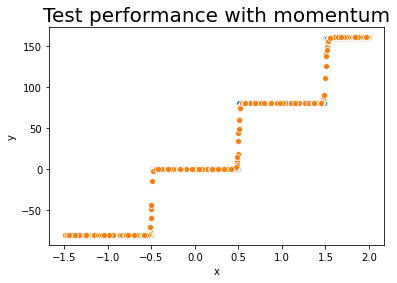

In [22]:
mymlp = mymlp = generate_random_mlp(1, [4], 1, start=0, stop=1)
start = time.time()
mymlp.train_momentum(np.asarray(train_df['x']).reshape(-1,1), np.asarray(train_df['y']).reshape(-1,1), 3000, 0.1)
end = time.time()
print("Czas uczenia z momentum: {}".format(end-start))
result = mymlp.forward_prop(np.asarray(test_df['x']).reshape(-1,1))
sns.scatterplot(x='x', y='y', data=test_df)
sns.scatterplot(x=test_df['x'], y=np.concatenate(result))
plt.title('Test performance with momentum', fontsize=20)

Neural Network attributes:
-------------------------
Number of neurons in layers: [1, 4, 1]
Number of predictors: 1
Number of hidden layers: 1
Number of targets: 1
Activations function used: sigmoid
Epoch: 0     Error: 8521.919417184516
Epoch: 2999  Error: 652.1918059606575


Text(0.5, 1.0, 'Test performance with rmsprop')

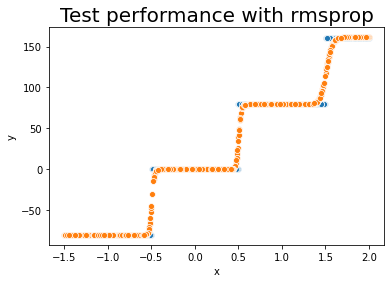

In [20]:
mymlp = generate_random_mlp(1, [4], 1)
mymlp.show_attributes()
mymlp.train_rmsPROP(np.asarray(train_df['x']).reshape(-1,1), np.asarray(train_df['y']).reshape(-1,1), 3000, 0.1, 0.9)
result = mymlp.forward_prop(np.asarray(test_df['x']).reshape(-1,1))
sns.scatterplot(x='x', y='y', data=test_df)
sns.scatterplot(x=test_df['x'], y=np.concatenate(result))
plt.title('Test performance with rmsprop', fontsize=20)

### Trzeci zbiór: multimodal-large

Text(0.5, 1.0, 'Train split')

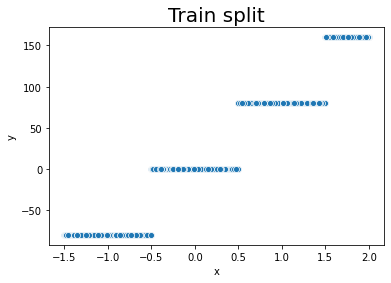

In [11]:
train_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/regression/multimodal-large-training.csv', index_col=0)
test_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/regression/multimodal-large-test.csv', index_col=0)
sns.scatterplot(x='x', y='y', data=train_df)
plt.title('Train split', fontsize=20)

Neural Network attributes:
-------------------------
Number of neurons in layers: [1, 4, 1]
Number of predictors: 1
Number of hidden layers: 1
Number of targets: 1
Activations function used: sigmoid
Epoch: 0     Error: 8560.062262023852
Epoch: 2999  Error: 664.5188826656168


Text(0.5, 1.0, 'Test performance standard')

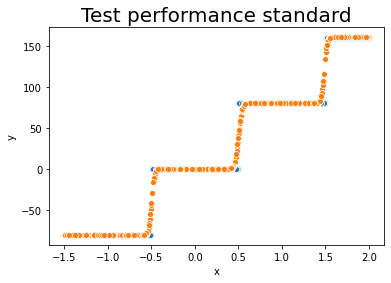

In [23]:
mymlp = generate_random_mlp(1, [4], 1)
mymlp.show_attributes()
mymlp.train(np.asarray(train_df['x']).reshape(-1,1), np.asarray(train_df['y']).reshape(-1,1), 3000, 0.1)
result = mymlp.forward_prop(np.asarray(test_df['x']).reshape(-1,1))
sns.scatterplot(x='x', y='y', data=test_df)
sns.scatterplot(x=test_df['x'], y=np.concatenate(result))
plt.title('Test performance standard', fontsize=20)

Epoch: 0     Error: 8519.746618853138
Epoch: 2999  Error: 406.0840577385853
Czas uczenia z momentum: 25.786120653152466


Text(0.5, 1.0, 'Test performance with momentum')

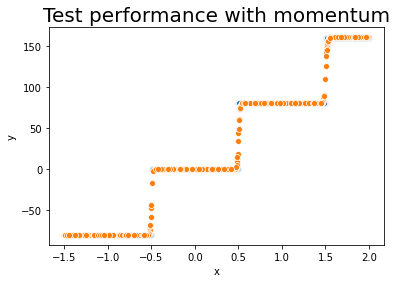

In [24]:
mymlp = mymlp = generate_random_mlp(1, [4], 1, start=0, stop=1)
start = time.time()
mymlp.train_momentum(np.asarray(train_df['x']).reshape(-1,1), np.asarray(train_df['y']).reshape(-1,1), 3000, 0.1)
end = time.time()
print("Czas uczenia z momentum: {}".format(end-start))
result = mymlp.forward_prop(np.asarray(test_df['x']).reshape(-1,1))
sns.scatterplot(x='x', y='y', data=test_df)
sns.scatterplot(x=test_df['x'], y=np.concatenate(result))
plt.title('Test performance with momentum', fontsize=20)

Neural Network attributes:
-------------------------
Number of neurons in layers: [1, 4, 1]
Number of predictors: 1
Number of hidden layers: 1
Number of targets: 1
Activations function used: sigmoid
Epoch: 0     Error: 8486.909836061997
Epoch: 2999  Error: 651.9198102561124


Text(0.5, 1.0, 'Test performance with rmsprop')

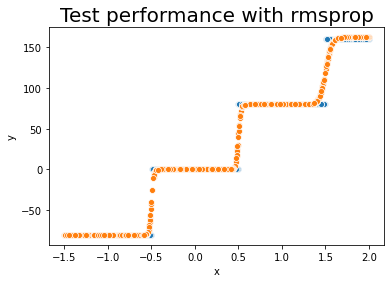

In [25]:
mymlp = generate_random_mlp(1, [4], 1)
mymlp.show_attributes()
mymlp.train_rmsPROP(np.asarray(train_df['x']).reshape(-1,1), np.asarray(train_df['y']).reshape(-1,1), 3000, 0.1, 0.9)
result = mymlp.forward_prop(np.asarray(test_df['x']).reshape(-1,1))
sns.scatterplot(x='x', y='y', data=test_df)
sns.scatterplot(x=test_df['x'], y=np.concatenate(result))
plt.title('Test performance with rmsprop', fontsize=20)